![imagen](https://patricioaraneda.cl/wp-content/uploads/2023/05/udla-logo-sm.png)
# Magíster en Data Science

# Examen Machine Learning I
# Alumno: Fernando José Toledo Rodríguez

## Problema 1: Clasificando departamentos

Suponga que usted trabaja en una entidad gubernamental de planificación urbana de una ciudad como científico de datos, y es parte de un proyecto de clasificación de inmuebles, y para ello, le solicitan estudiar datos de EEUU para luego aplicar esa metodología en Chile, ya que aún están en la etapa de recolección de datos, que como usted ya sabe, a veces puede ser lo más dificil de obtener en un proyecto centrado en datos.

Este dataset se encuentra en https://archive.ics.uci.edu/dataset/555/apartment+for+rent+classified

El objetivo de este problema es implementar un análisis completo de segmentación de departamentos. Para ello, siga estas indicaciones y responda si corresponde:

In [1]:
# Cargamos las librerias necesarias
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori, association_rules
import datetime as dt 
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from pycaret.anomaly import *
import matplotlib.cm as cm

#Aqui seteamos a que el código maximice la visualización de los datos
pd.set_option('display.max_columns', 40)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 640)

### Definición de los Campos 

- id = identificador único de la categoría del apartamento
- Categoría = categoría del título clasificado 
- Título = texto del título del apartamento 
- Cuerpo = texto del cuerpo del apartamento 
- Comodidades = aire acondicionado, baloncesto, televisión por cable, gimnasio, acceso a Internet, piscina, refrigerador, etc. 
- Baños = número de baños 
- Dormitorios = número de habitaciones 
- Moneda = precio actual 
- Tarifa = tarifa 
- Con_foto = foto del apartamento 
- Mascotas_permitidas = qué mascotas se permiten perros/gatos, etc.
- Precio = precio de alquiler del apartamento 
- Precio_mostrar = precio convertido en pantalla para el lector 
- Precio_tipo = precio en USD 
- Pies_cuadrados = tamaño del apartamento 
- Dirección = dónde está ubicado el apartamento 
- Nombre_Ciudad = dónde está ubicado el apartamento 
- Estado = dónde está ubicado el apartamento 
- Latitud = dónde está el apartamento está ubicado 
- Longitud = dónde se encuentra el apartamento 
- Fuente = origen del clasificado 
- Tiempo = cuándo se creó el clasificado sobre cada atributo en su conjunto de datos.

### Descargar el archivo adjunto. Puede escoger el dataset de 10.000 filas o de 100.000 filas

In [22]:
#Cargamos la data   
df_dpto = pd.read_csv("apartments_for_rent_classified_100K.csv", encoding='latin-1', sep=';')
df_dpto.head(2)

,id,category,title,body,amenities,bathrooms,bedrooms,currency,fee,has_photo,pets_allowed,price,price_display,price_type,square_feet,address,cityname,state,latitude,longitude,source,time
0,5668640009,housing/rent/apartment,One BR 507 & 509 Esplanade,"This unit is located at 507 & 509 Esplanade, Redondo Beach, 90277, CAMonthly rental rates range from $2195We have 1 beds units available for rent",NaN,1,1,USD,No,Thumbnail,Cats,2195.0,"$2,20",Monthly,542,507 509 Esplanade,Redondo Beach,CA,338.520,-1.183.759,RentLingo,1.577360e+09
1,5668639818,housing/rent/apartment,Three BR 146 Lochview Drive,"This unit is located at 146 Lochview Drive, Newport News, 23602, VAMonthly rental rates range from $1250We have 3 beds units available for rent",NaN,1.5,3,USD,No,Thumbnail,"Cats,Dogs",1250.0,"$1,25",Monthly,1500,146 Lochview Dr,Newport News,VA,370.867,-764.941,RentLingo,1.577360e+09


### Realizando un análisis y limpieza de datos adecuada

In [19]:
#Dimensiones
print(f'Número de filas: {df_dpto.shape[0]}')
print(f'Número de columnas: {df_dpto.shape[1]}')

Número de filas: 99826
Número de columnas: 22


In [25]:
df_dpto['bathrooms'] = pd.to_numeric(df_dpto['bathrooms'], errors='coerce')
df_dpto['bedrooms'] = pd.to_numeric(df_dpto['bedrooms'], errors='coerce')
df_dpto['price'] = pd.to_numeric(df_dpto['price'], errors='coerce')
df_dpto['square_feet'] = pd.to_numeric(df_dpto['square_feet'], errors='coerce')
df_dpto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99826 entries, 0 to 99825
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             99826 non-null  object 
 1   category       99826 non-null  object 
 2   title          99826 non-null  object 
 3   body           99826 non-null  object 
 4   amenities      83749 non-null  object 
 5   bathrooms      99757 non-null  float64
 6   bedrooms       99696 non-null  float64
 7   currency       99822 non-null  object 
 8   fee            99823 non-null  object 
 9   has_photo      99823 non-null  object 
 10  pets_allowed   44267 non-null  object 
 11  price          99821 non-null  float64
 12  price_display  99820 non-null  object 
 13  price_type     99823 non-null  object 
 14  square_feet    99821 non-null  float64
 15  address        7946 non-null   object 
 16  cityname       99521 non-null  object 
 17  state          99521 non-null  object 
 18  latitu

In [26]:
# valores nulos de todo el df
df_dpto.isnull().sum()

id                   0
category             0
title                0
body                 0
amenities        16077
bathrooms           69
bedrooms           130
currency             4
fee                  3
has_photo            3
pets_allowed     55559
price                5
price_display        6
price_type           3
square_feet          5
address          91880
cityname           305
state              305
latitude            29
longitude           31
source               6
time                 6
dtype: int64

In [27]:
#Pero si analizamos los datos nulos sólo de los campos cuantitativos
df_dpto[df_dpto.describe().columns].isnull().sum()

bathrooms       69
bedrooms       130
price            5
square_feet      5
latitude        29
time             6
dtype: int64

Se puede visualizar que la mayoría de los campos nulos se presentan sobre las variables cualitativas del set de datos, por lo que se procedera a crea el nuevo df de campos cuantitativos, para luego realizar la limpieza de datos

In [28]:
# Generamos las variables numericas del dataFrame
df_dpto.describe().columns

Index(['bathrooms', 'bedrooms', 'price', 'square_feet', 'latitude', 'time'], dtype='object')

Debido a la características de la descripción de los datos, se ha tomado la siguiente decidión para las variables cuantitativas:

- "id" es el identificador único de la categoría del apartamento, por ende una variable cualitativa.
- "latitude" es una variable numérica para ubicación, pero no aporta al análisis de clusterización.
- "longitude" es una variable numérica para ubicación, pero no aporta al análisis de clusterización.

In [29]:
df_cuanti = df_dpto[['bathrooms', 'bedrooms', 'price', 'square_feet']]
df_cuanti.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99826 entries, 0 to 99825
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bathrooms    99757 non-null  float64
 1   bedrooms     99696 non-null  float64
 2   price        99821 non-null  float64
 3   square_feet  99821 non-null  float64
dtypes: float64(4)
memory usage: 3.0 MB


In [30]:
# Confirmamos cuantos datos nulos hay por cada campo
df_cuanti.isnull().sum()

bathrooms       69
bedrooms       130
price            5
square_feet      5
dtype: int64

In [31]:
# Ralizamos la limpieza de datos y revisamos los nulos
df_cuanti = df_cuanti.dropna()
df_cuanti.isnull().sum()

bathrooms      0
bedrooms       0
price          0
square_feet    0
dtype: int64

In [32]:
df_cuanti.shape

(99633, 4)

### Realice un análisis descriptivo de datos. Concluya.

In [33]:
#tomando las columnas numéricas para estadística descriptiva
df_cuanti.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
bathrooms,99633.0,1.445776,0.546959,1.0,1.0,1.0,2.0,9.0
bedrooms,99633.0,1.728313,0.748578,0.0,1.0,2.0,2.0,9.0
price,99633.0,1527.399356,899.085492,100.0,1015.0,1350.0,1795.0,52500.0
square_feet,99633.0,956.020355,365.189468,107.0,730.0,900.0,1116.0,12000.0


In [34]:
#calculo de correlacion entre variables numericas
df_cuanti.corr()

,bathrooms,bedrooms,price,square_feet
bathrooms,1.000000,0.679942,0.329860,0.716336
bedrooms,0.679942,1.000000,0.236785,0.701021
price,0.329860,0.236785,1.000000,0.412372
square_feet,0.716336,0.701021,0.412372,1.000000


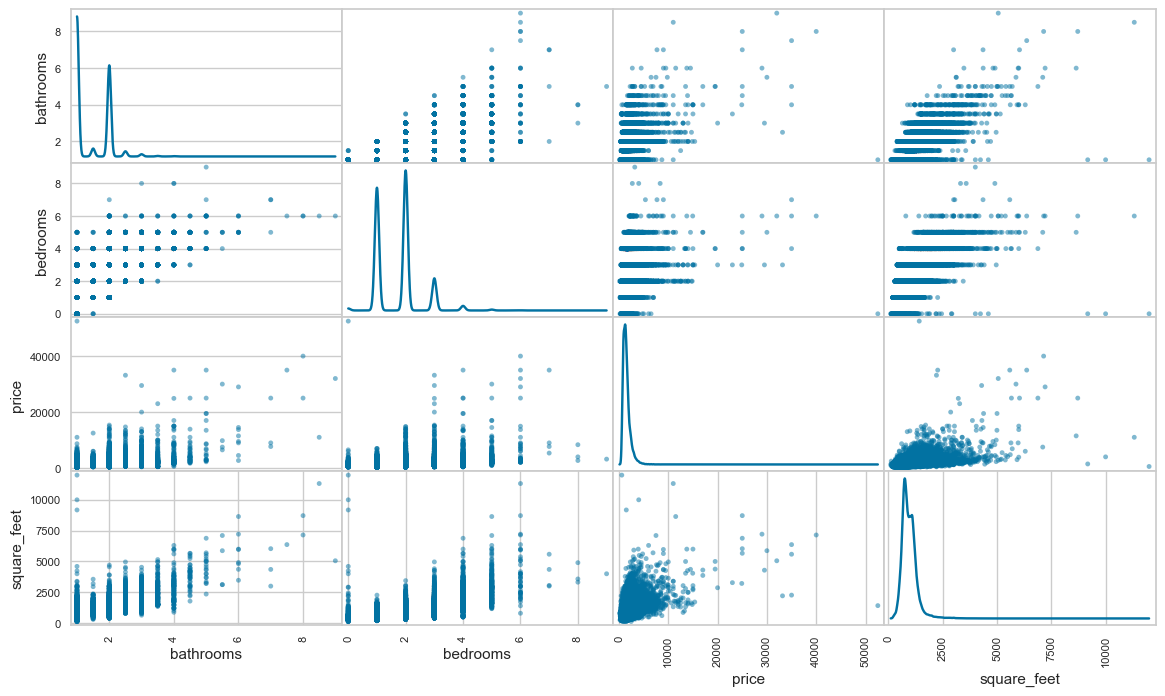

In [35]:
# Agregar estimaciones de densidad con gráficos de dispersión para comprobar simetría
pd.plotting.scatter_matrix(df_cuanti, figsize = (14,8), diagonal = 'kde');

##### Se puede apreciar que no existe un comportamiento homogeneo de las variables del dataset, por lo que se deberá realizar una *estandarización de los datos*

In [36]:
# Estandarizar las caracteristicas para tener media=0 y varianza=1
scaler = StandardScaler()
df_cuanti_std = scaler.fit_transform(df_cuanti)
df_cuanti_std = pd.DataFrame(df_cuanti_std, columns=['bathrooms', 'bedrooms', 'price', 'square_feet'])
df_cuanti_std.describe()

,bathrooms,bedrooms,price,square_feet
count,9.963300e+04,9.963300e+04,9.963300e+04,9.963300e+04
mean,-1.357857e-16,-2.011111e-17,-1.705879e-16,5.127621e-17
std,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00
min,-8.150124e-01,-2.308806e+00,-1.587620e+00,-2.324888e+00
25%,-8.150124e-01,-9.729333e-01,-5.699146e-01,-6.189157e-01
50%,-8.150124e-01,3.629394e-01,-1.973119e-01,-1.534016e-01
75%,1.013288e+00,3.629394e-01,2.976380e-01,4.380752e-01
max,1.381139e+01,9.714048e+00,5.669412e+01,3.024193e+01


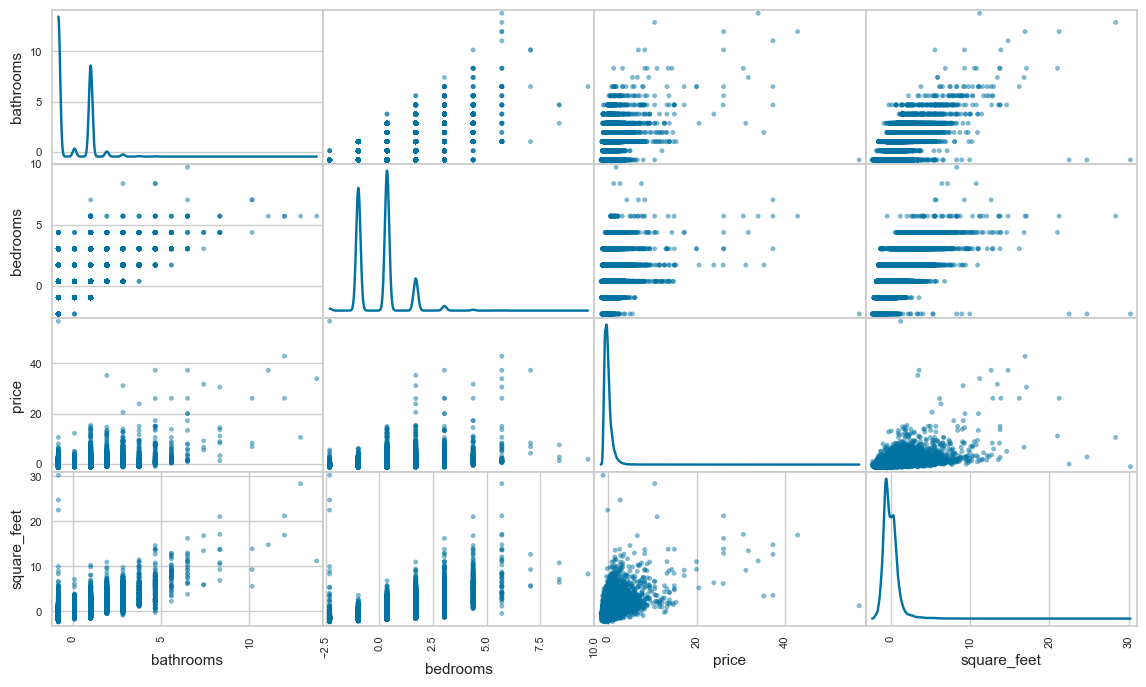

In [37]:
# Agregar estimaciones de densidad con gráficos de dispersión para comprobar simetría
pd.plotting.scatter_matrix(df_cuanti_std, figsize = (14,8), diagonal = 'kde');

### Realice la reducción de dimensiones, si es pertinente
##### Comenzamos con el análisis de componentes principales, de manera de poder determinar cuales aportan de mayor medida al modelo

In [38]:
pca = PCA(n_components=len(df_cuanti_std.columns))
pca.fit(df_cuanti_std)

PCA(n_components=4)

In [39]:
# PCA explained variance - Determinamos la explicación de viarianza por dimensión
ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1) #funcion de la varianza explicada
variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
variance_ratios

,Explained Variance
0,0.6499
1,0.2060
2,0.0781
3,0.0660


In [40]:
# Aplicamos la reducción de dimensiones con una tolerancia del 80%
TOL_pca = 0.8  #### MODIFICAR TOLERANCIA, 80 para arriba es aceptable (pensando Paretianamente)
n_comp = np.arange(len(df_cuanti_std.columns))
n_comp = 1+n_comp[(variance_ratios['Explained Variance'].cumsum()>=TOL_pca)][0]
print('Numero de Dimensiones seleccionadas: ',n_comp)

Numero de Dimensiones seleccionadas:  2


In [41]:
# Luego de llegar al número de dimensiones óptimo creamos el PCA ajustadp
pca_red = PCA(n_components=n_comp)
pca_red.fit(df_cuanti_std)

PCA(n_components=2)

In [42]:
## Finalmente la reducción de los datos
reduced_data = pca_red.transform(df_cuanti_std)
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension '+str(i+1) for i in range(n_comp)])
reduced_data

,Dimension 1,Dimension 2
0,-1.343084,1.222798
1,1.680738,-0.965772
2,2.462470,-1.001159
3,-0.434155,0.112691
4,-1.671418,-0.036615
...,...,...
99628,-1.773203,-0.233423
99629,0.422689,-1.031907
99630,-1.501169,0.317762
99631,-1.569552,-0.092397


In [43]:
def biplot(good_data, reduced_data, pca):

    fig, ax = plt.subplots(figsize = (14,8))
    # scatterplot of the reduced data    
    ax.scatter(x=reduced_data.loc[:, 'Dimension 1'], y=reduced_data.loc[:, 'Dimension 2'], 
        facecolors='b', edgecolors='b', s=70, alpha=0.5)
    
    feature_vectors = pca.components_.T

    # we use scaling factors to make the arrows easier to see
    arrow_size, text_pos = 7.0, 8.0,

    # projections of the original features
    for i, v in enumerate(feature_vectors):
        ax.arrow(0, 0, arrow_size*v[0], arrow_size*v[1], 
                  head_width=0.2, head_length=0.2, linewidth=2, color='red')
        ax.text(v[0]*text_pos, v[1]*text_pos, good_data.columns[i], color='black', 
                 ha='center', va='center', fontsize=18)

    ax.set_xlabel("Dimension 1", fontsize=14)
    ax.set_ylabel("Dimension 2", fontsize=14)
    ax.set_title("PC plane with original feature projections.", fontsize=16);
    return ax


<AxesSubplot:title={'center':'PC plane with original feature projections.'}, xlabel='Dimension 1', ylabel='Dimension 2'>

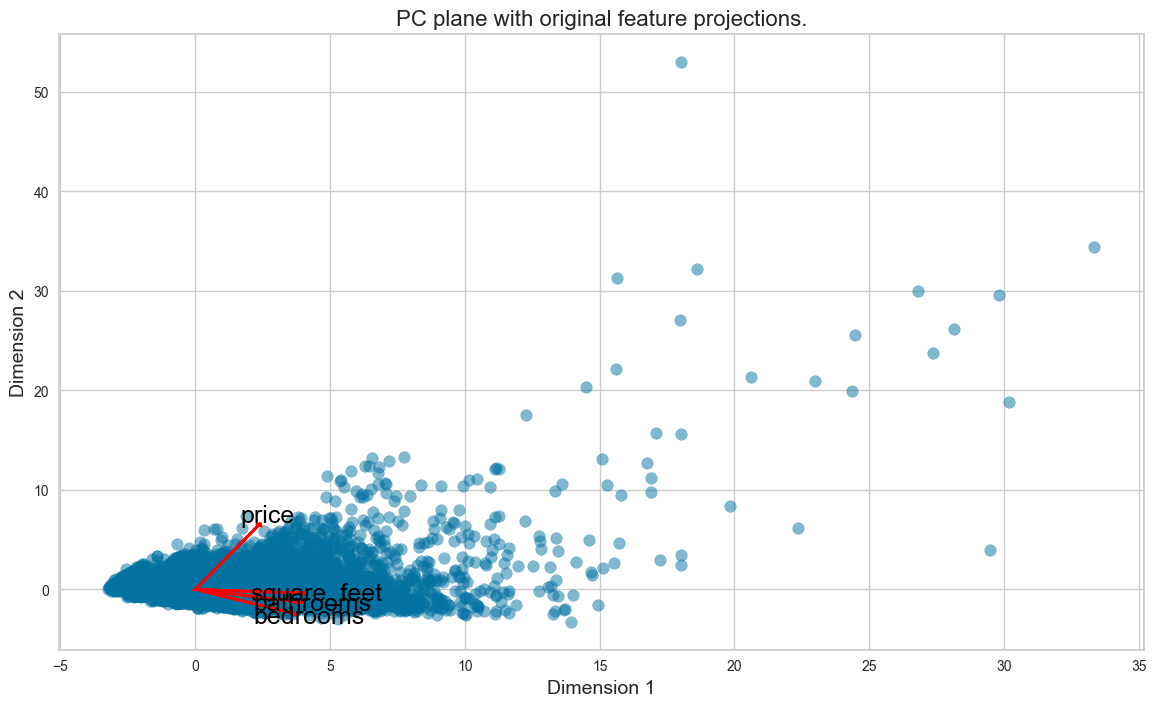

In [44]:
## Este grafico solo graficara las dos primeras dimensiones (que tienen mayor varianza explicada)
biplot(df_cuanti_std, reduced_data, pca)

In [45]:
# CLuesterizacion
s_scores=[]
range_n_clusters =  range(3,len(df_cuanti_std.columns))

# TODO: Apply your clustering algorithm of choice to the reduced data 
for i in range(3,len(df_cuanti_std.columns)):
    clusterer = KMeans(n_clusters=i, random_state=1,init='k-means++').fit(reduced_data)
    #clusterer = mixture.GaussianMixture(n_components=i, covariance_type='spherical')
      
    clusterer.fit(reduced_data)

    # TODO: Predict the cluster for each data point
    preds = clusterer.predict(reduced_data)
    
    # TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data, preds, random_state=1)
    s_scores.append(score)
    print("For n_clusters = {0}. The average silhouette_score is : {1}".format(i, score))

n_cluster = range_n_clusters[np.argmax(s_scores)]
print('Se seleccionaran '+str(n_cluster)+' clusters')

For n_clusters = 3. The average silhouette_score is : 0.5591380818532509
Se seleccionaran 3 clusters


In [46]:
clusterer_ = KMeans(n_clusters = n_cluster , random_state=42, init='k-means++')
#mixture.GaussianMixture(n_components= n_cluster, covariance_type='spherical')

clusterer_.fit(reduced_data)

# TODO: Predict the cluster for each data point
preds = clusterer_.predict(reduced_data)

# TODO: Find the cluster centers CENTROIDES
centers = clusterer_.cluster_centers_

In [47]:
def cluster_results(reduced_data, preds, centers):
	'''
	Visualizes the PCA-reduced cluster data in two dimensions
	Adds cues for cluster centers and student-selected sample data
	'''

	predictions = pd.DataFrame(preds, columns = ['Cluster'])
	plot_data = pd.concat([predictions, reduced_data], axis = 1)

	# Generate the cluster plot
	fig, ax = plt.subplots(figsize = (14,8))

	# Color map
	cmap = cm.get_cmap('gist_rainbow')

	# Color the points based on assigned cluster
	for i, cluster in plot_data.groupby('Cluster'):   
	    cluster.plot(ax = ax, kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2', \
	                 color = cmap((i)*1.0/(len(centers)-1)), label = 'Cluster %i'%(i), s=30);

	# Plot centers with indicators
	for i, c in enumerate(centers):
	    ax.scatter(x = c[0], y = c[1], color = 'white', edgecolors = 'black', \
	               alpha = 1, linewidth = 2, marker = 'o', s=200);
	    ax.scatter(x = c[0], y = c[1], marker='$%d$'%(i), alpha = 1, s=100);

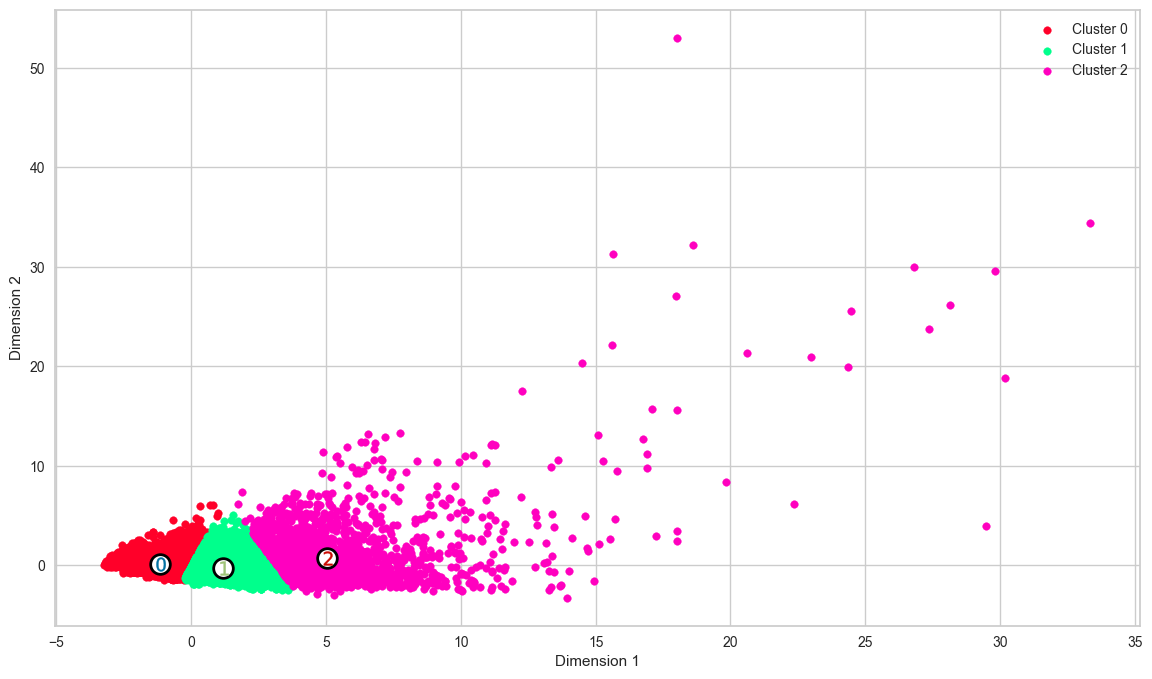

In [48]:
## Aqui graficamos los cluster y sus centroides
cluster_results(reduced_data, preds, centers)

In [49]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
output = tsne.fit_transform(df_cuanti_std)

In [50]:
print(pd.DataFrame(output, columns=['Dim_1', 'Dim_2']))

            Dim_1       Dim_2
0      -73.606415  121.251366
1       95.153343   -4.625284
2      135.704269  -21.066935
3      -13.167889   14.418102
4     -103.773041   -7.734602
...           ...         ...
99628 -110.442062  -56.778805
99629    1.471661 -126.939842
99630  -99.135529   48.573978
99631  -81.962868  -26.610258
99632   24.834761  -18.812859

[99633 rows x 2 columns]


<AxesSubplot:>

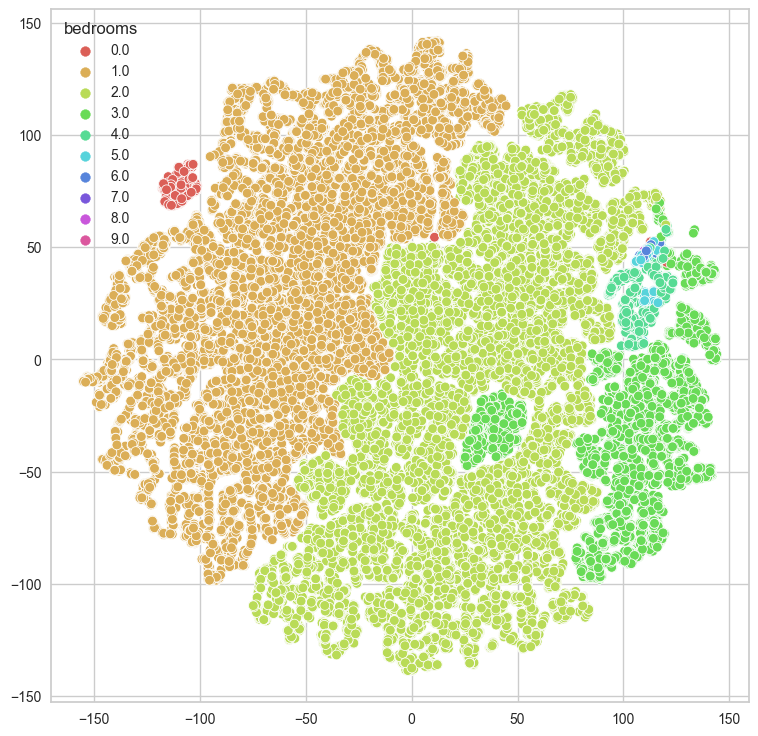

In [51]:
import numpy as np
import seaborn as sns
import matplotlib.patches as mpatches
palette = sns.color_palette("hls", 10)
fig,ax=plt.subplots(1,1,figsize=(9,9))
sns.scatterplot(x = output[:,0]
                , y = output[:,1]
                , hue = df_cuanti['bedrooms']
                , palette = palette
                , legend = 'full')

#### Conclusión Cluster
- PCA: entrega la relacion linean entre la cantidad de dormitorios, baños y metros cuadrados vs el precio del departamento, mostrando la agrupación entre los 3 factores principales
- TSNE: Muetra la relación completa entre el número de dormitorios y el resto de variables del grupo de datos, donde se puede apreciar que la mayor agrupación son los departamentos de 2 y 3 dormitorios en la base de daros.

In [52]:
# pasamos desde el espacio PCA al espacio canónico
sc_centers = pca_red.inverse_transform(centers)
sc_centers

array([[-0.67136933, -0.68107906, -0.22835336, -0.66824264],
       [ 0.69997666,  0.72747285,  0.13531414,  0.68349816],
       [ 2.60058434,  2.37968302,  2.41378459,  2.78517001]])

In [53]:
true_centers = pca.inverse_transform(sc_centers)
true_centers

array([[ 0.15631379,  0.00644611, -0.7580186 , -0.9023476 ],
       [-0.0850643 , -0.07499702,  0.79769816,  0.9249221 ],
       [-1.76481927,  0.99100521,  2.82640689,  3.73151497]])

In [54]:
true_true_centers = scaler.inverse_transform(true_centers)
true_true_centers   

array([[1.53127278e+00, 1.73313830e+00, 8.45879249e+02, 6.26494169e+02],
       [1.39924956e+00, 1.67217206e+00, 2.24459459e+03, 1.29379047e+03],
       [4.80497345e-01, 2.47015399e+00, 4.06856803e+03, 2.31872348e+03]])

In [55]:
# Display the true centers
segments = ['Cluster {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_true_centers), columns = df_cuanti.keys())
true_centers.index = segments
true_centers_df=pd.DataFrame(true_centers)
true_centers_df

,bathrooms,bedrooms,price,square_feet
Cluster 0,2.0,2.0,846.0,626.0
Cluster 1,1.0,2.0,2245.0,1294.0
Cluster 2,0.0,2.0,4069.0,2319.0


### COCLUSIONES CLUSTERIZACION

Se puede observar que bajo el modelo PCA se han determinado 3 cluster principales: 
- El cluster 0: Presenta una media de 2 dormitorios y el precio mas elevado debido a que son aquellas propiedades con el mayor número de metros cuadrados
- El cluster 1: Presenta el menor precio de los 3, acompañado de que es el que presenta el numero de metros cuadrados en sus propiedades
- El cluster 2: Presenta un precio promedio entre los otros cluester, al igual que la cantidad de metros cuadrados, con la misma relación de habitaciones y baños 

### ¿De qué manera sus conclusiones podrían cambiar cuando aplique este análisis al caso chileno?

Desde mi punto de vista la asignación y distribución de los cluster debería variar de forma importante, ya que uno de los componente principal del mismo es el espacio medido en pies cuadrados para el caso de EEUU, mientras que para el caso de Chile la distribución de los espacio en departamentos por metros cuadrados se encuentra mas acotada (menor espacio).

Esto debería generan en mi resultado, que la distrinción de los cluster no estaría tan marcada debido a que los tamaños de los departamentos en Chile se encuentra mas o menos estandarizada en los centros urbanos, presentando casi un formato tipo en los tamaños de departamentos de 1, 2 o 3 dormitorios. Ya que en nuestro mercado los departamentos de mas de 3 dormitorios pasaría a ser una especie de outlier y tratarmiento casi unico para nuestro mercado.

En conclusión el modelo actual debería volver a iterarse y entrenarse para la realizad del mercado chileno de acuerdo a la realidad de nuestro mercado inmobiliario.

### ¿Cómo la información cualitativa que descartó le podría servir para mejorar la clusterización? Si es posible, implemente un método que permita operar con variables cualitativas y re-interprete los resultados

Desde mi perspectiva la geolocalización sería una gran herramienta para poder determinar y mejorar la clusterización de manera de conocer por ubicación cuales son los espacios y cantidadde habitaciones que ofrece cada uno de los departamentos, de manera de poder validar en que sectores se encuentran las mejores propiedades para cada tipo de comprador.

Esta información sería útil mas bien para un modelo predictivo y de recomendación para la busqueda de propiedades según el perfil de cada uno de las personas que esten interesadas en buscar un departamento con ciertas características.

## Problema 2: Implementando un sistema de recomendación 

En la siguiente URL: https://tinyurl.com/4hs9db8n ud accederá a un repositorio donde se encuentra un dataset de compra de diferentes tipos de abarrotes. La primera columna es un identificador de boleta, la segunda es la fecha de compra y la tercera el producto comprado. 

Implemente un sistema recomendador usando como base el algoritmo Apriori. Para ello, debe hacer un análisis de datos adecuado para poder ejecutar el algoritmo. Compare diferentes agrupaciones temporales y concluya. 

**Opcional (puntaje bonus):** Si es posible, despliegue el sistema en un entorno web, de modo de constatar que el sistema recomendador funciona en un entorno e-commerce.

In [56]:
# Cargamos las librerias necesarias
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori, association_rules
import datetime as dt 
import os

#%matplotlib inline

from mlxtend.preprocessing import TransactionEncoder
import itertools

#Aqui seteamos a que el código maximice la visualización de los datos
pd.set_option('display.max_columns', 40)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 640)

In [64]:
#Cargamos la data   
ta = pd.read_csv("transacciones_abarrotes.csv", encoding='latin-1', sep=';')
ta.head(10)

,Member_number,Date,itemDescription
0,1000,24-06-2014,whole milk
1,1000,24-06-2014,pastry
2,1000,24-06-2014,salty snack
3,1000,15-03-2015,sausage
4,1000,15-03-2015,whole milk
5,1000,15-03-2015,semi-finished bread
6,1000,15-03-2015,yogurt
7,1000,27-05-2015,soda
8,1000,27-05-2015,pickled vegetables
9,1000,24-07-2015,canned beer


In [65]:
ta.shape

(38765, 3)

In [66]:
ta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    38765 non-null  int64 
 1   Date             38765 non-null  object
 2   itemDescription  38765 non-null  object
dtypes: int64(1), object(2)
memory usage: 908.7+ KB


## Preprocesamiento EDA

In [67]:
# data nulos
ta.isnull().sum()

Member_number      0
Date               0
itemDescription    0
dtype: int64

In [68]:
# dimensiones
print(f'Número de filas: {ta.shape[0]}')
print(f'Número de columnas: {ta.shape[1]}')

Número de filas: 38765
Número de columnas: 3


In [69]:
# estadistica
ta.describe().round(2).transpose()

,count,mean,std,min,25%,50%,75%,max
Member_number,38765.0,3003.64,1153.61,1000.0,2002.0,3005.0,4007.0,5000.0


<AxesSubplot:ylabel='itemDescription'>

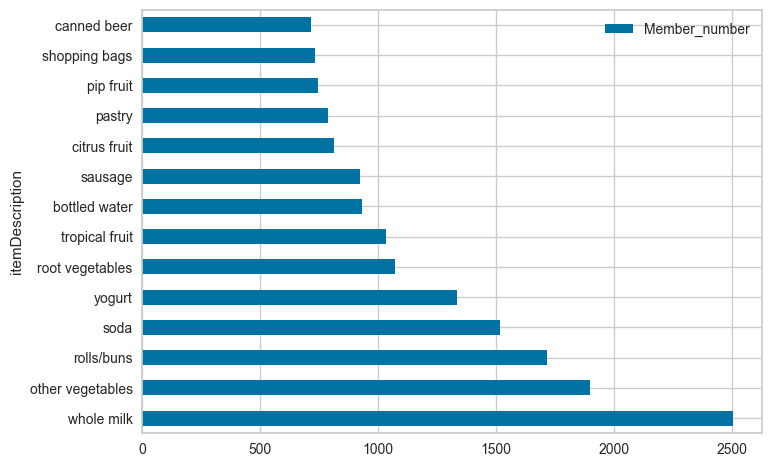

In [70]:
# agrupando por itemas mas comprados
Itemgrupo = ta.groupby('itemDescription').count()[['Member_number']]
ItemgrupoSort = Itemgrupo.sort_values(by='Member_number', ascending=False)

# visualizamos los 14 tipos de productos comprados
ItemgrupoSort.head(14).plot.barh()

In [71]:
# valores nulos
ta.isnull().sum()

Member_number      0
Date               0
itemDescription    0
dtype: int64

In [72]:
# Aqui creamos un nuevo DF que va a contar el número de compras por día de cada cliente
ta_qty_compras = ta[['Member_number', 'Date', 'itemDescription']]
ta_qty_compras['Compras_por_dia'] = ta.groupby(['Member_number', 'Date'])['Member_number'].transform('count')
ta_qty_compras

,Member_number,Date,itemDescription,Compras_por_dia
0,1000,24-06-2014,whole milk,3
1,1000,24-06-2014,pastry,3
2,1000,24-06-2014,salty snack,3
3,1000,15-03-2015,sausage,4
4,1000,15-03-2015,whole milk,4
...,...,...,...,...
38760,5000,16-11-2014,bottled beer,2
38761,5000,16-11-2014,other vegetables,2
38762,5000,10-02-2015,soda,3
38763,5000,10-02-2015,root vegetables,3


In [73]:
def matriz(dataframe, id=False):
  if id:
    return dataframe.groupby(['Member_number', 'itemDescription'])['Compras_por_dia'].sum().unstack().fillna(0).applymap(lambda x:1 if x > 0 else 0)
  else:
    return dataframe.groupby(['Member_number', 'itemDescription'])['Compras_por_dia'].sum().unstack().fillna(0).applymap(lambda x: 1 if x > 0 else 0)

productos = matriz(ta_qty_compras, id=True)
productos.head()

itemDescription,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,beverages,bottled beer,bottled water,brandy,brown bread,butter,butter milk,cake bar,candles,candy,...,specialty vegetables,spices,spread cheese,sugar,sweet spreads,syrup,tea,tidbits,toilet cleaner,tropical fruit,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
Member_number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
1001,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0
1002,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
1003,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1004,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0


In [74]:
# seleccion de productos
seleccion = apriori(productos, min_support= 0.01, use_colnames=True)
seleccion.head()

,support,itemsets
0,0.015393,(Instant food products)
1,0.078502,(UHT-milk)
2,0.031042,(baking powder)
3,0.119548,(beef)
4,0.079785,(berries)


In [75]:
#metricas generadas por reglas de asociación
reglas = association_rules(seleccion, metric='support', min_threshold=0.01)
reglas.sort_values(by='support', ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
1868,(other vegetables),(whole milk),0.376603,0.458184,0.191380,0.508174,1.109106,0.018827,1.101643,0.157802
1869,(whole milk),(other vegetables),0.458184,0.376603,0.191380,0.417693,1.109106,0.018827,1.070564,0.181562
2048,(whole milk),(rolls/buns),0.458184,0.349666,0.178553,0.389698,1.114484,0.018342,1.065592,0.189591
2049,(rolls/buns),(whole milk),0.349666,0.458184,0.178553,0.510638,1.114484,0.018342,1.107190,0.157955
2187,(whole milk),(soda),0.458184,0.313494,0.151103,0.329787,1.051973,0.007465,1.024310,0.091184


In [76]:
reglas = reglas.drop(0)
reglas = reglas.reset_index(drop=True)
reglas

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(beef),(UHT-milk),0.119548,0.078502,0.010518,0.087983,1.120775,0.001133,1.010396,0.122392
1,(UHT-milk),(bottled beer),0.078502,0.158799,0.014879,0.189542,1.193597,0.002413,1.037933,0.176014
2,(bottled beer),(UHT-milk),0.158799,0.078502,0.014879,0.093700,1.193597,0.002413,1.016769,0.192815
3,(UHT-milk),(bottled water),0.078502,0.213699,0.021293,0.271242,1.269268,0.004517,1.078960,0.230217
4,(bottled water),(UHT-milk),0.213699,0.078502,0.021293,0.099640,1.269268,0.004517,1.023477,0.269801
...,...,...,...,...,...,...,...,...,...,...
15474,(rolls/buns),"(soda, other vegetables, whole milk, yogurt)",0.349666,0.027963,0.013597,0.038885,1.390578,0.003819,1.011364,0.431893
15475,(whole milk),"(soda, yogurt, other vegetables, rolls/buns)",0.458184,0.020010,0.013597,0.029675,1.483002,0.004428,1.009961,0.601111
15476,(soda),"(yogurt, other vegetables, whole milk, rolls/buns)",0.313494,0.034377,0.013597,0.043372,1.261658,0.002820,1.009403,0.302098
15477,(yogurt),"(soda, other vegetables, whole milk, rolls/buns)",0.282966,0.031811,0.013597,0.048051,1.510499,0.004595,1.017059,0.471340


In [77]:
def recomendacion(dataframe, idproducto, support=0.03, numproductos=5):
    reglas_filtradas = reglas[reglas['support'] >= support] # Filtrar las reglas que cumplan con el soporte mínimo
    recomendaciones = reglas_filtradas[reglas_filtradas['antecedents'].apply(lambda x: idproducto in x)]
    recomendaciones = recomendaciones.sort_values('consequents', ascending=False) # Ordenar las recomendaciones por confianza en orden descendente
    productos_recomendados = recomendaciones['consequents'].head(numproductos).tolist() # Obtener los productos recomendados
    productos_recomendados = [list(item)[0] for item in productos_recomendados]
    
    return productos_recomendados

In [78]:
prodcuto_comprado = ta_qty_compras['itemDescription'][4]
cliente1 = recomendacion(ta_qty_compras,prodcuto_comprado)
print(f"Productos recomendados para la compra de: '{prodcuto_comprado}' es: {cliente1}")

Productos recomendados para la compra de: 'whole milk' es: ['UHT-milk', 'pastry', 'pip fruit', 'other vegetables', 'tropical fruit']


## Problema 3: Detección de anomalías

Basado en un dataset que contiene mediciones del **consumo de energía eléctrica** en un hogar con una tasa de muestreo de un minuto durante un período de casi 4 años. Están disponibles diferentes magnitudes eléctricas y algunos valores de submedición.

**Dataset**: [https://patricioaraneda.cl/public_data/household_power_consumption.txt](https://patricioaraneda.cl/public_data/household_power_consumption.txt)

Información de atributos:
1. dt: Fecha en formato dd/mm/aaaa hh:mm:ss
2. Global_active_power: potencia activa global promediada por minuto del hogar (en kilovatios)
3. Global_reactive_power: potencia reactiva global media por minuto del hogar (en kilovatios)
4. voltage: voltaje medio por minuto (en voltios)
5. Global_intensity: intensidad de corriente promediada por minutos global del hogar (en amperios)
6. Sub_metering_1: submedición de energía nº 1 (en vatios-hora de energía activa). Corresponde a la cocina, que contiene principalmente un lavavajillas, un horno y un microondas (las placas no son eléctricas sino de gas).
7. Sub_metering_2: submedición de energía nº 2 (en vatios-hora de energía activa). Corresponde al lavadero, que contiene una lavadora, una secadora, un frigorífico y una luz.
8. Sub_metering_3: submedición de energía nº 3 (en vatios-hora de energía activa). Corresponde a un calentador de agua eléctrico y a un aire acondicionado.

### Indicaciones

Complete el código solicitado y atengase a responder las preguntas asociadas. Recuerde que hay muchas formas de encontrar soluciones entre las muchas funciones disponibles para ello. Elija la mejor disponible.

Las librerías mostradas son solo referenciales, sea libre de elegir las que necesite.

Recuerde; sin E.D.A. no hay Data Science. 


In [79]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

Cargue los datos en un objeto llamado 'df'

In [80]:
# Se realiza carga 
df = pd.read_csv('https://patricioaraneda.cl/public_data/household_power_consumption.txt', sep=';')
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


1. ¿Cuantos registros tiene el dataset?

In [81]:
# ingrese su codigo y su respuesta
print(f'El dataset tiene {df.shape[0]} registros')

El dataset tiene 2075259 registros


2. ¿Cuál es el tipo de la variable 'Voltage'

In [82]:
# ingrese su codigo y su respuesta
df.dtypes

Date                      object
Time                      object
Global_active_power       object
Global_reactive_power     object
Voltage                   object
Global_intensity          object
Sub_metering_1            object
Sub_metering_2            object
Sub_metering_3           float64
dtype: object

3. ¿cuáles son los valores mínimo y máximo de la variable 'Voltage'?

In [83]:
# ingrese su codigo y su respuesta

# Debido a que el archivo tiene valores "?" dentro de sus datos, es que se procede a reemplazar por valores nulos 
# luego se convierte el campo a numérico para buscar el mínimo y máximo
print("El valor mínimo de la variable 'Voltage' es:", pd.to_numeric(df['Voltage'].replace('?', np.nan)).min())
print("El valor máximo de la variable 'Voltage' es:", pd.to_numeric(df['Voltage'].replace('?', np.nan)).max())

El valor mínimo de la variable 'Voltage' es: 223.2
El valor máximo de la variable 'Voltage' es: 254.15


4. ¿Existe alguna variable con más del 30% de valores faltantes?

In [84]:
# ingrese su codigo y su respuesta
(df.replace('?', np.nan).isnull().sum() / df.shape[0]) * 100

Date                     0.000000
Time                     0.000000
Global_active_power      1.251844
Global_reactive_power    1.251844
Voltage                  1.251844
Global_intensity         1.251844
Sub_metering_1           1.251844
Sub_metering_2           1.251844
Sub_metering_3           1.251844
dtype: float64

#### Actualmente la base no presentan campos con mas de un 30% de datos faltantes

5. ¿Cuál es la cantidad de variables categóricas en el dataset? y numéricas?

In [85]:
# ingrese su codigo y su respuesta
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


De acuerdo a la definición de cada uno de los campos, ninguno de ellos es de carcacter categórica, ya que tienen unidad de medida

1. dt: Fecha en formato dd/mm/aaaa hh:mm:ss
2. Global_active_power: potencia activa global promediada por minuto del hogar (en kilovatios)
3. Global_reactive_power: potencia reactiva global media por minuto del hogar (en kilovatios)
4. voltage: voltaje medio por minuto (en voltios)
5. Global_intensity: intensidad de corriente promediada por minutos global del hogar (en amperios)
6. Sub_metering_1: submedición de energía nº 1 (en vatios-hora de energía activa). Corresponde a la cocina, que contiene principalmente un lavavajillas, un horno y un microondas (las placas no son eléctricas sino de gas).
7. Sub_metering_2: submedición de energía nº 2 (en vatios-hora de energía activa). Corresponde al lavadero, que contiene una lavadora, una secadora, un frigorífico y una luz.
8. Sub_metering_3: submedición de energía nº 3 (en vatios-hora de energía activa). Corresponde a un calentador de agua eléctrico y a un aire acondicionado.

6. Para los algoritmos de clustering el dataset no puede tener instancias con datos faltantes. ¿Tiene este dataset datos faltantes?

In [86]:
# ingrese su codigo y su respuesta
df.replace('?', np.nan).isnull().sum()

Date                         0
Time                         0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

7. Si existieran datos faltantes, se prescindirá de ellos.

In [87]:
# omita los datos faltantes si es que existen.

# Primero se creará un nuevo df, donde reemplazo los datos "?" por datos nulos
df2 = df.replace('?', np.nan)

# Luego procedo a eliminar las filas con datos nulos
df2 = df2.dropna()

# Finalmente confirmo con cuantos registros quedo en mi nuevo df2
df2.shape

(2049280, 9)

In [88]:
df2.isnull().sum()

Date                     0
Time                     0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

8. Determine las correlaciones de Pearson de las variables.

In [89]:
# establezca la correlación entre variables

# Primero se trabajará el df2 para que las variables sean del tipo numéricas
df2['Date'] = pd.to_datetime(df2['Date'], format='%d/%m/%Y')
df2['Global_active_power'] = pd.to_numeric(df2['Global_active_power']).round(3)
df2['Global_intensity'] = pd.to_numeric(df2['Global_intensity']).round(3)
df2['Voltage'] = pd.to_numeric(df2['Voltage']).round(3)
df2['Global_reactive_power'] = pd.to_numeric(df2['Global_reactive_power']).round(3)
df2['Sub_metering_1'] = pd.to_numeric(df2['Sub_metering_1']).round(3)
df2['Sub_metering_2'] = pd.to_numeric(df2['Sub_metering_2']).round(3)
df2['Sub_metering_3'] = pd.to_numeric(df2['Sub_metering_3']).round(3)

df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2049280 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Date                   datetime64[ns]
 1   Time                   object        
 2   Global_active_power    float64       
 3   Global_reactive_power  float64       
 4   Voltage                float64       
 5   Global_intensity       float64       
 6   Sub_metering_1         float64       
 7   Sub_metering_2         float64       
 8   Sub_metering_3         float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 156.3+ MB


In [90]:
# Ahora puedo determinar la matriz de correlación de Pearson
df2.corr(method="pearson")

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Global_active_power,1.000000,0.247017,-0.399762,0.998889,0.484401,0.434569,0.638555
Global_reactive_power,0.247017,1.000000,-0.112246,0.266120,0.123111,0.139231,0.089617
Voltage,-0.399762,-0.112246,1.000000,-0.411363,-0.195976,-0.167405,-0.268172
Global_intensity,0.998889,0.266120,-0.411363,1.000000,0.489298,0.440347,0.626543
Sub_metering_1,0.484401,0.123111,-0.195976,0.489298,1.000000,0.054721,0.102571
Sub_metering_2,0.434569,0.139231,-0.167405,0.440347,0.054721,1.000000,0.080872
Sub_metering_3,0.638555,0.089617,-0.268172,0.626543,0.102571,0.080872,1.000000


9. ¿Puede eliminar alguna variable? si es así eliminelas. Analice y justifique su elección.

In [91]:
# elimine variables que considere factibles de eliminar

# Se precindirá de la variables "Date" y "Time" para el análisis debido a que para nuestro análisis marca un intervalo de tiempo para la mediciones del DF.

# Generaremos un nuevo "df2"
df2 = df2.drop(['Date', 'Time'], axis=1)
df2

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,3.666,0.528,235.68,15.8,0.0,1.0,17.0
...,...,...,...,...,...,...,...
2075254,0.946,0.000,240.43,4.0,0.0,0.0,0.0
2075255,0.944,0.000,240.00,4.0,0.0,0.0,0.0
2075256,0.938,0.000,239.82,3.8,0.0,0.0,0.0
2075257,0.934,0.000,239.70,3.8,0.0,0.0,0.0


10.¿Algún gráfico al menos preliminar para mostrar los datos de mayor interés?

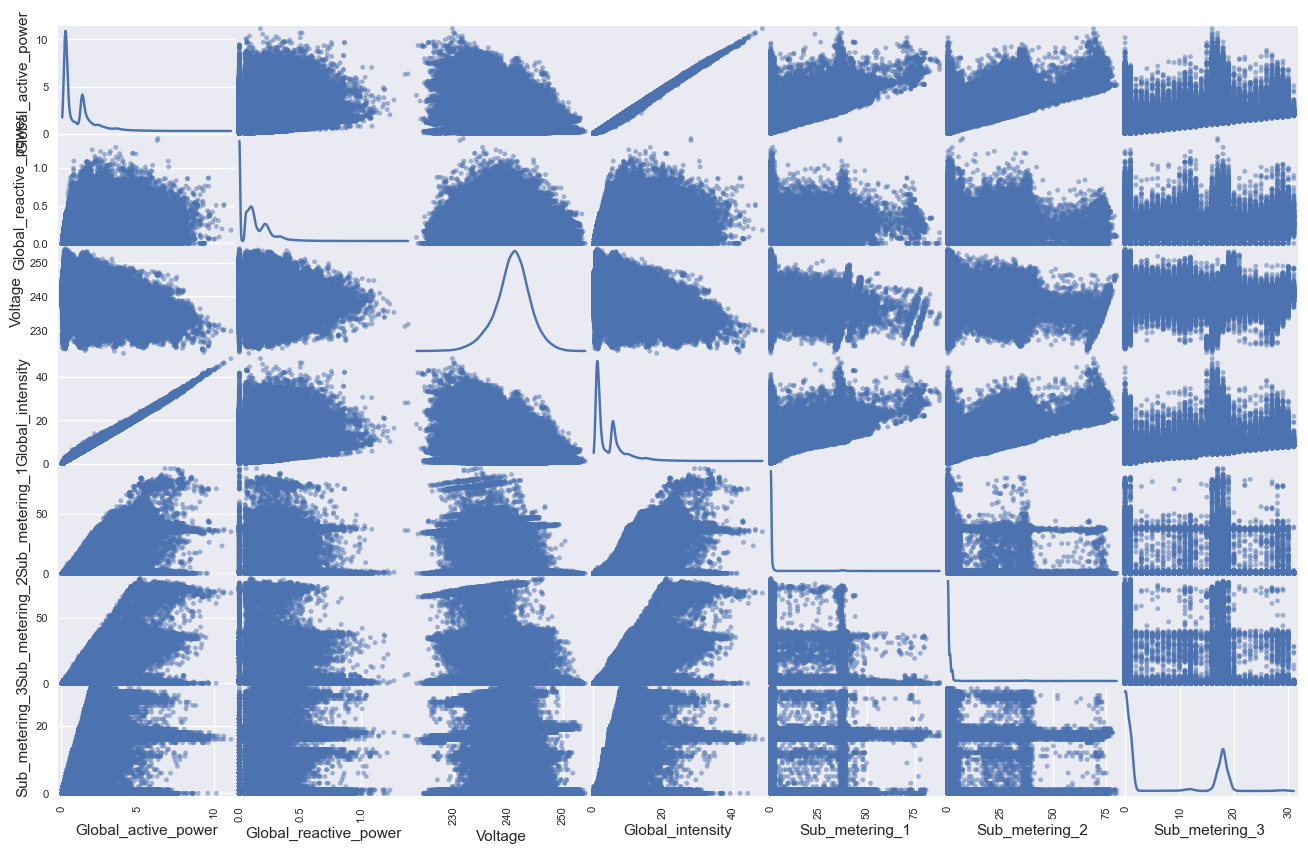

In [92]:
# presente uno o mas gráficos para "conocer" los datos de interés.
pd.plotting.scatter_matrix(df2, figsize = (16,10), diagonal = 'kde');

### Bien, ahora podemos entrar en materia.

Basado en el algoritmo del Bosque de aislamiento (Isolation forest) realice **los procedimientos necesarios** para detectar si hay o no **valores anómalos** en el dataset.

- Reserve un 5% de los datos iniciales para pruebas del modelo con datos no vistos.
- Utilice del restante el 80% para entrenamiento y el 20% para test
- Defina y ajuste el modelo.
- Evalue el modelo.
- Determine la cantidad de anomalías.
- Efectúe una predicción sobre el 5% de datos reservados del inicio.

In [93]:
# procedimientos

# Reservamos el 5% de los datos iniciales
no_visto = df2.sample(frac=0.05, random_state=1)
no_visto.shape

(102464, 7)

In [94]:
# Generamos el grupo con los casos retantes
resto = df2.drop(no_visto.index)
resto.shape

(1946816, 7)

In [95]:
# Generamos el grupo entrenamiento y test
entrenamiento = resto.sample(frac=0.8, random_state=1)
test = resto.drop(entrenamiento.index)
print(entrenamiento.shape[0])
print(test.shape[0])

1557453
389363


In [96]:
# Creamos el modelo iforest
from pycaret.anomaly import *
s = setup(entrenamiento, session_id = 123)

iforest = create_model('iforest')
print(iforest)

# Evaluamos el modelo 
evaluate_model(iforest)

,Description,Value
0,Session id,123
1,Original data shape,"(1557453, 7)"
2,Transformed data shape,"(1557453, 7)"
3,Numeric features,7
4,Preprocess,True
5,Imputation type,simple
6,Numeric imputation,mean
7,Categorical imputation,mode
8,CPU Jobs,-1
9,Use GPU,False


IForest(behaviour='new', bootstrap=False, contamination=0.05,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=-1,
    random_state=123, verbose=0)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [97]:
# Generamos el cluster
cluster = create_model('cluster')
print(cluster)

# Evaluamos el modelo sobre el cluster
evaluate_model(cluster)

CBLOF(alpha=0.9, beta=5, check_estimator=False, clustering_estimator=None,
   contamination=0.05, n_clusters=8, n_jobs=None, random_state=123,
   use_weights=False)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

### Asignar  el modelo iforest
Asignamos la etiqueta de anomalía (1= outlier; 0=normal)

In [98]:
# functional API
result = assign_model(iforest)
result.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Anomaly,Anomaly_Score
1297141,0.214,0.092,236.720001,1.0,0.0,1.0,1.0,0,-0.165318
1587015,2.192,0.046,244.309998,8.8,0.0,0.0,18.0,0,-0.141081
872899,0.174,0.152,241.160004,0.8,0.0,0.0,1.0,0,-0.190874
882421,0.168,0.150,245.029999,0.8,0.0,1.0,0.0,0,-0.175620
1498344,0.238,0.000,245.110001,1.0,0.0,0.0,0.0,0,-0.209545


### Predicciones

Generación de etiquetas de anomalias usando el modelo entrenado sobre nuevos datos.

In [99]:
predictions = predict_model(iforest, data = test)
predictions.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Anomaly,Anomaly_Score
26,3.236,0.000,235.84,13.6,0.0,0.0,17.0,0,-0.082295
36,2.790,0.180,237.52,11.8,0.0,0.0,18.0,0,-0.141871
47,3.090,0.152,237.07,13.8,0.0,12.0,17.0,0,-0.063498
48,3.730,0.144,235.78,16.4,0.0,27.0,17.0,0,-0.000752
50,2.388,0.158,237.26,10.0,0.0,1.0,17.0,0,-0.159626


### Procederemos a guardar el modelo

In [100]:
save_model(iforest, 'iforest_pipeline')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=C:\Users\ftoledor\AppData\Local\Temp\joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['Global_active_power',
                                              'Global_reactive_power', 'Voltage',
                                              'Global_intensity',
                                              'Sub_metering_1', 'Sub_metering_2',
                                              'Sub_metering_3'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('trained_model',
                  IForest(behaviour='new', bootstrap=False, contamination=0.05,
     max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=-1,
     random_state=123, verbose=0))]),
 'iforest_pipeline.pkl')

### Cargamos y replicamos el modelo con el universo de Test

In [101]:
# Cargamos el modelo
loaded_model = load_model('iforest_pipeline')
loaded_model

Transformation Pipeline and Model Successfully Loaded


Pipeline(memory=FastMemory(location=C:\Users\ftoledor\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['Global_active_power',
                                             'Global_reactive_power', 'Voltage',
                                             'Global_intensity',
                                             'Sub_metering_1', 'Sub_metering_2',
                                             'Sub_metering_3'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=[],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('trained_model',
                 IForest(behaviour='new', bootstrap=False, contamination=0.05,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=-1,
    random_state=123, verbose=0))])

In [106]:
# aplicar el modelo sobre test
new_prediction = predict_model(loaded_model, data=test)
new_prediction.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Anomaly,Anomaly_Score
26,3.236,0.000,235.839996,13.6,0.0,0.0,17.0,0,-0.082295
36,2.790,0.180,237.520004,11.8,0.0,0.0,18.0,0,-0.141871
47,3.090,0.152,237.070007,13.8,0.0,12.0,17.0,0,-0.063498
48,3.730,0.144,235.779999,16.4,0.0,27.0,17.0,0,-0.000752
50,2.388,0.158,237.259995,10.0,0.0,1.0,17.0,0,-0.159626


Incluya un plot 3d TSNE para los outliers

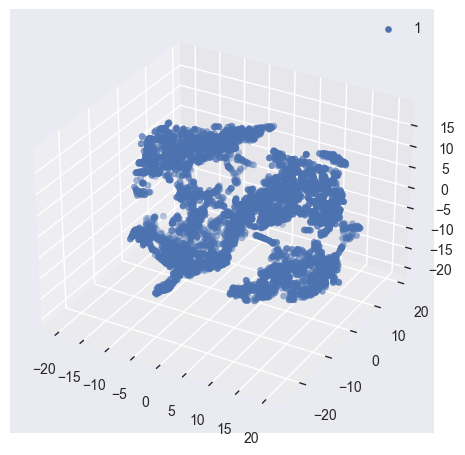

In [103]:
# Plot 3D solo de las anomalías con TSNE

from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

df_unseen_outliers = no_visto[loaded_model.predict(no_visto) == 1]

n_components = min(3, df_unseen_outliers.shape[1])
tsne = TSNE(n_components=n_components, random_state=42)
X_tsne = tsne.fit_transform(df_unseen_outliers)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

unique_categories = np.unique(loaded_model.predict(df_unseen_outliers)).tolist()

for category in unique_categories:
    category_outliers = df_unseen_outliers[loaded_model.predict(df_unseen_outliers) == category]
    X_category_tsne = X_tsne[loaded_model.predict(df_unseen_outliers) == category]
    ax.scatter(X_category_tsne[:, 0], X_category_tsne[:, 1], X_category_tsne[:, 2], label=category)

plt.legend()
plt.show()


In [104]:
unique_categories = np.unique(loaded_model.predict(df_unseen_outliers)).tolist()
unique_categories

[1]

Pruebe el modelo obtenido.

In [105]:
# aplicar el modelo sobre los daros no vistos y reservados
new_prediction = predict_model(loaded_model, data=no_visto)
new_prediction.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Anomaly,Anomaly_Score
1872886,1.338,0.084,240.779999,5.600000,0.0,0.0,18.0,0,-0.216787
732709,1.660,0.206,240.440002,7.000000,0.0,0.0,19.0,0,-0.185950
289951,0.362,0.346,241.490005,2.000000,0.0,1.0,0.0,0,-0.151590
288919,1.332,0.208,238.389999,5.600000,0.0,2.0,17.0,0,-0.157087
1129172,4.940,0.438,242.330002,20.799999,30.0,0.0,18.0,1,0.101423
